## MO436 - Tópicos em Aprendizado de Máquina: Reinforcement Learning - 2s2020

### Projeto 1
Leandro Rebes Camargo, 150960 | Mauricio de Sousa Araujo, 184477 | Raysa Masson Benatti, 176483

#### Introdução

O objetivo deste trabalho é aplicar métodos de aprendizado por reforço para resolver um problema definido pelo grupo. No nosso caso, optamos por estudar e resolver o problema do <b>CartPole</b>. 
    
Conforme definido por Barto, Sutton e Anderson [[1]](#Referências), trata-se de um sistema simulado que representa um pêndulo invertido. Nessa simulação, o <b>agente</b> é um carrinho que se move em um trilho sem atrito de uma dimensão, para a esquerda ou direita; ligado ao carrinho, encontra-se uma estaca, que se move angularmente, em sentido horário ou anti-horário. O objetivo do problema é colocar o carrinho em movimento de modo que a estaca (pêndulo) permaneça ereta. 

Para atingir esse objetivo, devemos controlar as variáveis do modelo. São quatro variáveis, que definem os <b>estados</b> do sistema: (1) a posição <b>p</b> do carrinho no trilho; (2) a velocidade <b>v</b> do carrinho; (3) o ângulo <b>a</b> que a estaca forma com o eixo vertical do carrinho; (4) a velocidade angular <b>va</b> de movimento da estaca.

O modelo tem duas <b>ações</b> possíveis: movimentar o carrinho sobre o trilho para a esquerda ou para a direita.

Um estado desse sistema é <b>terminal</b> nas seguintes situações: (1) se o módulo do ângulo <b>a</b> é maior que 12 graus (o que representa, na prática, a queda da estaca); (2) se o centro do carrinho atinge alguma borda do ambiente; (3) se a quantidade máxima de episódios definida é atingida. O estado terminal (1) é considerado fracasso; os estados terminais (2) e (3) são bem-sucedidos e representam o objetivo do problema <b>se</b>, quando são atingidos, o carrinho se movimenta com a estaca ereta. Por padrão, a cada ação tomada, o ambiente fornece ao agente um <i>feedback</i> --- ou <b>recompensa</b> --- no valor de 1; se a ação resulta em um estado (1) ou (2), o ambiente enviará um <i>failure signal</i> através da variável booleana ``done``, cujo valor será modificado de ``False`` para ``True``. Caso a ação faça a estaca cair (estado (1)), a recompensa será zero.

O ambiente se caracteriza como <b>estocástico</b>, pois não é possível determinar o resultado a partir de um estado atual, e <b>episódico</b>, pois o agente pode tomar qualquer uma das ações disponíveis a qualquer momento, sem que uma ação afete as demais. 


#### Visualização do ambiente

Para implementar e explorar o problema, usamos o ambiente CartPole-v0 do <i>toolkit</i> OpenAI Gym [[2]](#Referências). A execução do código abaixo importa o ambiente e as bibliotecas necessárias, além de plotar uma amostra de imagem do carrinho e seus arredores.

In [1]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [8]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
import numpy as np
import time
env = gym.make("CartPole-v0")

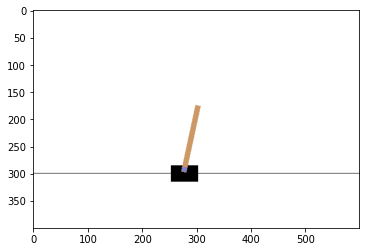

In [128]:
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for i in range(50):
    action = env.action_space.sample() 
    #0 = ir para trás, 1 = ir pra frente
    obs, reward, done, info = env.step(action) 
    #obs é um vetor com 4 valores: Position, Cart Velocity, Angle, Angle Velocity
    screen = env.render(mode='rgb_array')
    
    plt.imshow(screen)
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())
    
    if(done):
        break
    
ipythondisplay.clear_output(wait=True)
env.close()

#### Discretização

Para discretizar o ambiente originalmente contínuo, criamos uma classe ``Discretizer``, que recebe como parâmetros o limite inferior, o limite superior e a quantidade de <i>bins</i> a serem criados. Tais parâmetros podem ser customizados conforme o mais adequado para cada método, verificado experimentalmente. Cada uma das variáveis --- posição, velocidade, ângulo e velocidade angular --- é discretizada e usada para constituir um estado válido a partir da função ``gen_state``. O código abaixo implementa essa lógica e imprime 20 exemplos de estados válidos. 

In [10]:
class Discretizer:
    def __init__(self,nbins,lower,high):
        '''
        Discretizamos um intervalo que vai de lower até high em nbins. 
        Todos valores do lower receberam um mesmo valor de estado,
        assim como os acima de high
        '''
        self.nbins=nbins
        self.high=high
        self.lower=lower
        self.thresholds=np.array([])
        self.fit()
    def fit(self):
        step=(self.high-self.lower)/self.nbins 
        self.thresholds = np.arange(self.lower, self.high, step) 
    def transform(self,x):
        return np.digitize(x,self.thresholds)

position_discretizer = Discretizer(nbins = 1000 ,lower = env.observation_space.low[0], high = env.observation_space.high[0]) 
velocity_discretizer = Discretizer(nbins = 1000, lower = -100 , high = 100  ) 
angle_discretizer = Discretizer(nbins = 1000 ,lower = env.observation_space.low[2], high = env.observation_space.high[2])
velocity_angle_discretizer = Discretizer(nbins = 100, lower = -10 , high = 10) 

gen_state = lambda  p, v, a, va : ( position_discretizer.transform(p), velocity_discretizer.transform(v), 
                                    angle_discretizer.transform(a), velocity_angle_discretizer.transform(va) )

#Sample
#Position, Velocity, Angle, Velocity Angle
env.reset()
for i in range(20):
    action = env.action_space.sample() #0 ir para trás, 1 ir pra frente
    obs, reward, done= env.step(action)[:3] #obs é um vetor com 4 valores, Position, Cart Velocity, Angle, Angle Velocity
    p, v, a, va=obs
    print(gen_state(p,v,a,va)) #Discretiza e gera estados válidos

(502, 502, 463, 49)
(502, 503, 455, 47)
(503, 503, 440, 46)
(504, 503, 418, 47)
(505, 502, 403, 49)
(505, 503, 394, 47)
(506, 502, 377, 48)
(507, 501, 366, 50)
(507, 502, 362, 48)
(507, 503, 350, 46)
(508, 502, 330, 48)
(508, 503, 317, 46)
(509, 502, 295, 47)
(510, 503, 279, 45)
(511, 504, 255, 44)
(512, 505, 222, 42)
(514, 504, 181, 43)
(515, 505, 146, 41)
(517, 506, 101, 39)
(519, 507, 48, 37)


/home/ray/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Os limites inferior e superior das variáveis <b>posição</b> e <b>ângulo</b> são aqueles definidos como padrão no ambiente: $p \in [-4.8, 4.8]$ e $a \in [-24, 24]$ (em graus). As variáveis <b>velocidade</b> e <b>velocidade angular</b> têm limites infinitos; assim, devemos definir manualmente seus limites. Como padrão, escolhemos $v \in [-100, 100]$ e $va \in [-10, 10]$, além de uma discretização de 1000 <i>bins</i> para <b>p</b>, <b>v</b> e <b>a</b>, e de 100 <i>bins</i> para <b>va</b>.

#### Monte Carlo Control

O aprendizado por reforço pelo método de Monte Carlo consiste em que o agente, após completar um episódio inteiro, seja informado sobre o valor da recompensa obtida; o <i>state value</i> é aprendido a partir de uma média de N amostras de episódios que foram iniciados em um mesmo estado. O código abaixo implementa essa lógica.

In [35]:
class monte_Carlo():
    def __init__(self, gamma = 0.9, n_episodes = 1000,n0 = 1):
        self.n_episodes = n_episodes
        self.gamma = gamma
        self.n0 = n0
        self.n_visits = {}
        self.Q={}
        self.Q_opt={}
        self.states=set()
        self.policy={}
        self.values=[]
        self.sample_state = (498, 501, 516, 51)
      
    def main(self):
        for  i in range(1,self.n_episodes+1):
            env.reset()
            #Inicializamos com um estado
            obs = env.step(env.action_space.sample())[0]
            p, v, a, va=obs
            init_state = gen_state(p,v,a,va) #Discretiza e gera estados válidos
            self.update_Q(init_state)
            self.values.append( max( self.Q_opt.get(self.sample_state, {}).get((1), 0), 
                                   self.Q_opt.get(self.sample_state, {}).get((0), 0)) )
        self.improvement_policy()
      
  
    def update_Q(self, old_state):
        '''
        Utilizamos umas estrutura recursiva para atualizar Q
        '''
        self.states.add(old_state)
        action = (env.action_space.sample()) #0 ir para trás, 1 ir pra frente
        obs, reward, done= env.step(action)[:3] #obs é um vetor com 4 valores, Position, Cart Velocity, Angle, Angle Velocity
        p, v, a, va = obs
        new_state = gen_state(p,v,a,va) #Discretiza e gera estados válidos
        Gt=0
        if(done==False):
            Gt=self.gamma*self.update_Q(new_state)
        Gt=Gt+reward
        self.n_visits[(old_state, action)] = self.n_visits.get((old_state, action),0) + 1 #Para casa visita acrescenta 1 
        self.Q[(old_state, action)] = self.Q.get((old_state, action),0)+(Gt-self.Q.get((old_state, action),0))/self.n_visits[(old_state, action)]
    
        #Rescreve Q para Q_opt para melhor acesso
        if(self.Q_opt.get(old_state)):
            self.Q_opt.get(old_state).update({action : self.Q[(old_state, action)]})
        else:
            self.Q_opt[old_state] = {action:self.Q[(old_state, action)]} 
        return Gt
    
    def improvement_policy(self):
        '''
        Balanceamento exploration x exploitation
        '''
        for st in self.states:
            n=self.n_visits.get((st,0),0)+self.n_visits.get((st,1),0)#Número de vezes que o estado foi visitado
            ek=self.n0/(self.n0+n)
            maximo=np.max(self.Q_opt[st].values())
            for a in self.Q_opt[st].keys():
                if(maximo == self.Q_opt[st][a]):
                    self.policy[(st,a)]=ek/2+1-ek
                else:
                    self.policy[(st,a)]=ek/2

Abaixo, variamos a quantidade de episódios --- entre 10 e 1.000.000 --- para verificar como o algoritmo se comporta. 

In [16]:
#Variamos o número de episodes para MC
mcs=[]
for i in range(1,7):
    start_time = time.time()
    mc=monte_Carlo(n_episodes=10**i)
    mc.main()
    mcs.append(mc)
    end_time = time.time()
    total_time = end_time - start_time
    print("Tempo total de execução para 10^{} episódios: {} segundos".format(i, total_time))

Tempo total de execução para 10^1 episódios: 0.021251916885375977 segundos
Tempo total de execução para 10^2 episódios: 0.1813983917236328 segundos
Tempo total de execução para 10^3 episódios: 1.4292020797729492 segundos
Tempo total de execução para 10^4 episódios: 14.787602186203003 segundos
Tempo total de execução para 10^5 episódios: 150.23499703407288 segundos
Tempo total de execução para 10^6 episódios: 1392.6903173923492 segundos


Além de calcular o tempo de execução, também computamos a média de quantas ações o pêndulo executa antes de cair, o que nos dá uma ideia da evolução do aprendizado do sistema. Quanto mais episódios, mais ações são executadas antes de o sistema falhar, o que representa o aprendizado esperado. 

In [17]:
def mean_actions(Q,n=100):
    '''
    Fazemos a média de quantas ações o pêndulo faz antes de cair 
    '''
    mean=0
    for i in range(n):
        env.reset()
        obs, reward, done = env.step(env.action_space.sample())[:3]
        p, v, a, va=obs
        state = gen_state(p,v,a,va) #Discretiza e gera estados válidos
        k=0
        while(done==False):
            #Se caso o estado não for alcançado, ele escolhe uma ação randomica
            s1 = Q.get((state,(1)), env.action_space.sample()) 
            s2 = Q.get((state,(0)), env.action_space.sample())
            action = 1 if(s1>s2) else 0
            obs, reward, done, info = env.step(action) #obs é um vetor com 4 valores, Position, Cart Velocity, Angle, Angle Velocity
            p, v, a, va=obs
            state = gen_state(p,v,a,va) #Discretiza e gera estados válidos
            k+=1
        mean+=k
    mean=mean/n
    return mean

means = []
for m in mcs:
    means.append(mean_actions(m.Q))
means

[14.37, 14.49, 16.76, 32.74, 93.38, 136.42]

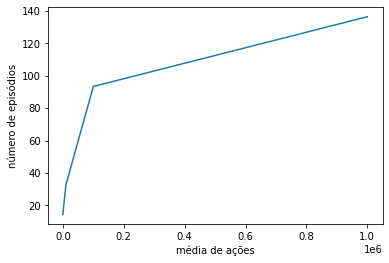

In [18]:
#Plot
eps = [10, 100, 1000, 10000, 100000, 1000000]
y = means
plt.xlabel("média de ações")
plt.ylabel("número de episódios")
plt.plot(eps, y)

Abaixo, geramos a representação gráfica dos valores de Q ao longo da execução do algoritmo, que mostra a convergência para 100.000 episódios.

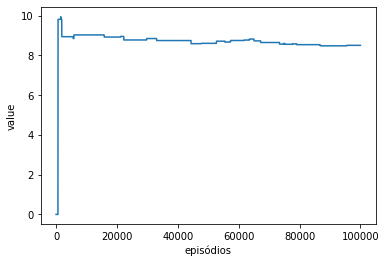

In [40]:
mc=monte_Carlo(n_episodes=100000)
mc.main()
x = list(range(1,mc.n_episodes+1))
y = mc.values
plt.ylabel("value")
plt.xlabel("episódios")
plt.plot(x, y)

Abaixo, geramos a visualização do ambiente. O comportamento do agente neste algoritmo, após convergência, pode ser assistido [neste vídeo](https://streamable.com/9ljzsq).

In [29]:
#Sample view
def visualizacao(Q):
    env.reset()
    obs, reward, done = env.step(env.action_space.sample())[:3]
    p, v, a, va=obs
    state = gen_state(p,v,a,va) #Discretiza e gera estados válidos
    k=0
    while(done==False):
        s1 = Q.get((state,(1))) if(Q.get((state,(1)))) else env.action_space.sample()
        s2 = Q.get((state,(0))) if(Q.get((state,(0)))) else env.action_space.sample()
        action = 1 if(s1>s2) else 0
        obs, reward, done, info = env.step(action) #obs é um vetor com 4 valores, Position, Cart Velocity, Angle, Angle Velocity
        p, v, a, va=obs
        state = gen_state(p,v,a,va) #Discretiza e gera estados válidos
        time.sleep(0.1)
        k+=1
        env.render()
    env.close()

mc_better = mcs[-1]
visualizacao(mc_better.Q)

#### Q-learning

O algoritmo Q-learning tem como objetivo aprender a função valor que melhor resolverá o problema no ambiente. A intiuição é que, dado um estado, o agente será informado sobre qual a melhor ação a ser tomada de modo a maximizar a expectativa de ganho futuro. O Q-learning pode ser definido canonicamente segundo a fórmula abaixo (Equação de Bellman), em que:
- $max_{a} Q(s_{t+1}, a)$ é a estimativa de valor ótimo futuro para uma ação $a$;
- $Q(s_{t}, a_{t})$ é a estimativa no estado $s_{t}$ atual;
- $\alpha$ é a taxa de aprendizado (<i>learning rate</i>), que varia de 0 a 1 e representa quão rápido o algoritmo aprende a função;
- $\gamma$ é o fator de desconto (<i>discount factor</i>), que varia de 0 a 1 e representa a proporção de importância dada à recompensa em longo prazo. 

\begin{equation}
Q(s_{t}, a_{t}) \leftarrow Q(s_{t}, a_{t}) + \alpha \cdot (r_{t} + \gamma \cdot max_{a} Q(s_{t+1}, a) - Q(s_{t}, a_{t}))
\end{equation}

O código abaixo, adaptado de Richard Brooker [[3]](#Referências), implementa essa lógica, seguindo os passos:
- Inicializar a ``Q_table`` com zeros; 
- Criar funções para: implementar a política gulosa de selecionar o maior valor Q da tabela; atualizar a função valor; definir uma taxa de aprendizado adaptativa, que diminui com o tempo; definir uma taxa de exploração adaptativa, que diminui com o tempo para gradativamente privilegiar exploitação;
- Definir os níveis de discretização;
- Definir a quantidade de episódios;
- Executar o modelo. 

Os parâmetros escolhidos para execução definitiva do modelo, determinados experimentalmente, são:
- Quantidade de <i>bins</i>: 10 para cada variável (para ordens de grandeza maiores, o armazenamento de ``Q_table`` se tornava impraticável);
- Domínios de variáveis padrão, exceto para velocidade angular, em que $va \in [-50, 50]$ (em radianos);
- 1000 episódios (iterações) (para ordens de grandeza maiores, o tempo de execução se tornava muito longo);
- Fator de desconto 1.

In [144]:
n_bins=(11,11,11,11)

#Inicializa tabela com zeros
Q_table = np.zeros(n_bins + (env.action_space.n,))
Q_table.shape

(11, 11, 11, 11, 2)

In [152]:
#Cria policy function; usa Q-table para selecionar o maior Q
def policy( state : tuple ):
    return np.argmax(Q_table[state])

#Atualiza função valor
def new_Q_value( reward : float ,  new_state : tuple , discount_factor=1 ) -> float:
    future_optimal_value = np.max(Q_table[new_state])
    learned_value = reward + discount_factor * future_optimal_value
    return learned_value

#Taxa de aprendizado adaptativa
def learning_rate(n : int , min_rate=0.01 ) -> float  :
    return max(min_rate, min(1.0, 1.0 - math.log10((n + 1) / 25)))

#Taxa de exploração adaptativa; tradeoff exploração-exploitação
def exploration_rate(n : int, min_rate= 0.1 ) -> float :
    return max(min_rate, min(1, 1.0 - math.log10((n  + 1) / 25)))

In [153]:
#Discretização
env.reset()

position_discretizer = Discretizer(nbins = 10 ,lower = env.observation_space.low[0], high = env.observation_space.high[0]) 
velocity_discretizer = Discretizer(nbins = 10, lower = -100 , high = 100  ) 
angle_discretizer = Discretizer(nbins = 10 ,lower = env.observation_space.low[2], high = env.observation_space.high[2])
velocity_angle_discretizer = Discretizer(nbins = 10, lower = -math.radians(50) , high = math.radians(50)) 

gen_state = lambda  p, v, a, va : ( position_discretizer.transform(p), velocity_discretizer.transform(v), 
                                   angle_discretizer.transform(a), velocity_angle_discretizer.transform(va) )

In [156]:
#Training e execução
n_episodes = 1000 
q_values = [] 

start_time = time.time()

for e in range(n_episodes):

    #Inicializamos com um estado
    env.reset()
    obs = env.step(env.action_space.sample())[0]
    p, v, a, va=obs
    current_state = gen_state(p,v,a,va) #Discretiza e gera estado válido

    done = False

    while done==False:
        
        # Policy action 
        action = policy(current_state) # exploit
        
        # Insere ação aleatória
        if np.random.random() < exploration_rate(e) : 
            action = env.action_space.sample() # explore 
         
        # Atualiza ambiente
        obs, reward, done, _ = env.step(action)
        p, v, a, va = obs
        new_state = gen_state(p,v,a,va)
        
        # Atualiza Q-Table
        lr = learning_rate(e)
        learnt_value = new_Q_value(reward , new_state)
        old_value = Q_table[current_state][action]
        Q_table[current_state][action] = (1-lr)*old_value + lr*learnt_value
        q_values.append(Q_table[current_state][action])
        
        current_state = new_state
        
        # Render do ambiente
        env.render()
        
    
end_time = time.time()
total_time = end_time - start_time
print("Tempo total de execução: {} segundos".format(total_time))

Tempo total de execução: 296.2074270248413 segundos


Abaixo, plotamos a variação dos valores de Q em função do tempo. O gráfico mostra que o algoritmo convergiu rapidamente para a solução.

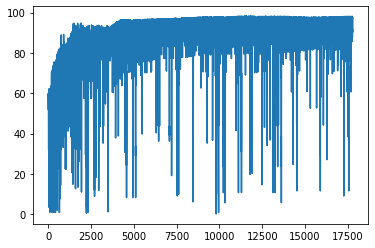

In [157]:
#episodes = np.arange(0, n_episodes, 1)
x = np.arange(0, len(q_values), 1)
plt.plot(x, q_values)
plt.show()

A visualização do comportamento do cartpole neste algoritmo, após convergência, encontra-se [neste vídeo](https://streamable.com/of543q).

#### Sarsa-Lambda

O algoritmo Sarsa (acrônimo para <i>state–action–reward–state–action</i>) é usado em aprendizado por reforço para que um agente aprenda a política de um processo decisório de Markov. A fórmula que o sintetiza encontra-se abaixo, em que:
- $Q(s_{t}, a_{t})$ é a estimativa de valor obtido de uma ação $a$ tomada em um estado $s$;
- $\alpha$ é a taxa de aprendizado (<i>learning rate</i>), que varia de 0 a 1 e representa quão rápido o algoritmo aprende a função;
- $r_{t+1}$ é a recompensa associada à tomada de uma ação $a$ em um estado $s$ num tempo $t$;
- $\gamma$ é o fator de desconto (<i>discount factor</i>), que varia de 0 a 1 e representa a proporção de importância dada à recompensa em longo prazo. 

\begin{equation}
Q(s_{t}, a_{t}) \leftarrow Q(s_{t}, a_{t}) + \alpha \cdot [r_{t+1} + \gamma \cdot Q(s_{t+1}, a_{t+1}) - Q(s_{t}, a_{t}))]
\end{equation}

Sarsa-Lambda é uma variação de Sarsa em que cada par estado-ação tem um traço de eligibilidade. O código abaixo implementa sua lógica.

In [32]:
class sarsa_lambda():
    def __init__(self, policy={}, n_episodes=1000, gamma=0.9, lamb = 1, alpha = 0.9):
        self.n_episodes = n_episodes
        self.gamma = gamma
        self.lamb = lamb
        self.alpha = alpha
        self.E = {}
        self.Q = {}

    def choose_action(self,s):
        if(policy.get(s)):
            porcen0 = policy[s].get(0) or 0
            aux=round(porcen0*10)
            v=np.array(aux*[0]+(10-aux)*[1])
            np.random.shuffle(v)
            return np.random.choice(v,1)[0]
        else:
            return env.action_space.sample()

    def main(self):
        for e in range(self.n_episodes):
            env.reset()
            obs = env.step(env.action_space.sample())[0]
            p, v, a, va=obs
            s1 = gen_state(p,v,a,va) #Discretiza e gera estados válidos
            action1 = env.action_space.sample()
            done=False
            while(done==False):
                obs, reward, done = env.step(action1)[:3]
                p, v, a, va=obs   
                s2 = gen_state(p,v,a,va)
                action2=self.choose_action(s2) #Escolhe uma ação com base em uma política
                delta = reward+self.gamma*self.Q.get((s2,action2),0 )-self.Q.get((s1,action1),0 )
                self.E[(s1,action1)]=self.E.get((s1,action1),0)+1
                for st_a in self.E.keys():
                    self.Q[st_a] = self.Q.get(st_a, 0) + self.alpha*delta*self.E[st_a]
                    self.E[st_a] = self.gamma*self.lamb*self.E[st_a]
                s1=s2
                action1=action2
mc_better = mcs[-1]
policy = mc_better.policy
lambs =[0, 0.2, 0.4, 0.6, 0.8, 1]
sarsas = []
start_time = time.time()
for lamb in lambs:
    sarsa=sarsa_lambda(policy, lamb=lamb)
    sarsa.main()
    sarsas.append(sarsa)
    
end_time = time.time()
total_time = end_time - start_time
print("Tempo total de execução: {} segundos".format(total_time))

Tempo total de execução: 1468.7461330890656 segundos


O gráfico abaixo mostra a média de ações executadas para cada valor de lambda. Como não houve convergência para 1000 episódios, não há nenhum padrão observável nessa visualização. Caso houvesse aprendizado satisfatório, possivelmente haveria um lambda para o qual a quantidade média de ações seria otimizada.

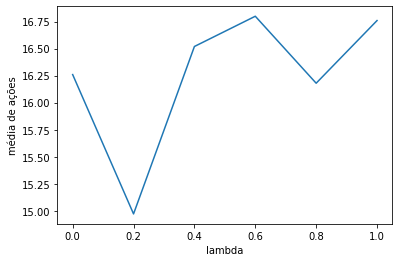

In [34]:
means = []
for s in sarsas:
    means.append(mean_actions(s.Q))

lambdas = [0, 0.2, 0.4, 0.6, 0.8, 1]
y = means
plt.ylabel("média de ações")
plt.xlabel("lambda")
plt.plot(lambdas, y)

#### Aproximador de função linear

Aproximadores de função não foram implementados. 

#### Síntese dos resultados e discussões

- <b>Comparação entre algoritmos</b>:

|           |Tempo para execução e aprendizado| Resultado|
|-----------|---------------------------------|----------|
|Monte Carlo|Execução total em 1.43 segundos (1000 episódios); aprendizado em aproximadamente 10% do tempo|Satisfatório, com convergência para solução|
|Q-learning|Execução total em 296 segundos (1000 episódios); aprendizado em aproximadamente 20% do tempo|Satisfatório, com convergência para solução|
|Sarsa-Lambda|Execução total em 1468 segundos (1000 episódios)|Não houve convergência|

Para 1000 episódios, Sarsa-Lambda foi o único algoritmo que não alcançou convergência, além de ser o de execução mais lenta, possivelmente em razão dos traços de eligibilidade associados a cada par estado-ação. Assumindo o tempo de execução como indicador de complexidade computacional (dado que as versões definitivas de todos os experimentos foram executadas na mesma máquina), Sarsa-Lambda é o algoritmo mais complexo, seguido por Q-learning e Monte Carlo Control. Ressaltamos, também, que Q-learning atingiu resultados tão satisfatórios quanto Monte Carlo Control mesmo com uma discretização mais grosseira. 

- <b>Considerações sobre a função de recompensa</b>: O modelo de recompensa que usamos privilegia a manutenção do mastro em pé, punindo o agente com recompensa zero somente quando o mastro cai. Por esse motivo, consideramos esperado o comportamento do agente de não se locomover fora de uma zona central do trilho --- o contrário, por exemplo, do que ocorre [nesta demonstração](https://www.youtube.com/watch?v=5SEEwqRH8_c). Ainda assim, o resultado foi satisfatório para os algoritmos Monte Carlo Control e Q-learning. 

#### Descrição das tarefas do grupo

Todos os membros do grupo participaram da etapa de definição/estudo do problema. As demais tarefas foram realizadas por apenas dois dos integrantes, conforme descrito abaixo: 

- Mauricio: Estudo, implementação, testes e visualizações dos algoritmos Monte Carlo Control e Sarsa-Lambda; Visualização do ambiente; Discretização. 
- Raysa: Estudo, implementação, testes e visualizações do algoritmo Q-learning; Visualização do ambiente; Vídeos; Escrita e organização do relatório.  

OBS.: o grupo foi originalmente constituído por quatro pessoas, conforme especificação, mas um dos membros abandonou a disciplina. 

#### Referências

[1] A. G. Barto, R. S. Sutton and C. W. Anderson, "Neuronlike adaptive elements that can solve difficult learning control problems," in <i>IEEE Transactions on Systems, Man, and Cybernetics</i>, vol. SMC-13, no. 5, pp. 834-846, Sept.-Oct. 1983, doi: 10.1109/TSMC.1983.6313077.

[2] OpenAI Gym: CartPole-v0. https://gym.openai.com/envs/CartPole-v0/ 

[3] Q-learning-demo-Cartpole-V1 by Richard Brooker. https://github.com/RJBrooker/Q-learning-demo-Cartpole-V1